# Experimental speckle phase retrieval

### Imports and data loading

Load the libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from scipy.io import loadmat
import mat73
import speckleret as spr

data_path = 'C:/ML/datasets/data_base_CP_CL_f_60mm_2_cameras_6_6.mat'

Load the interferometric data

In [2]:
CL = mat73.loadmat(data_path)['CL']
CP = mat73.loadmat(data_path)['INTERFERENCE']

print(len(CL), len(CL[0]), CL[0][0].shape)
print(len(CP), len(CP[0]), CP[0][0].shape)

2 1000 (512, 512)
2 1000 (256, 256)


### Data cleanup: noise removal and centroid detection

Let's remove the noise from the measured far field

10.41777712724969


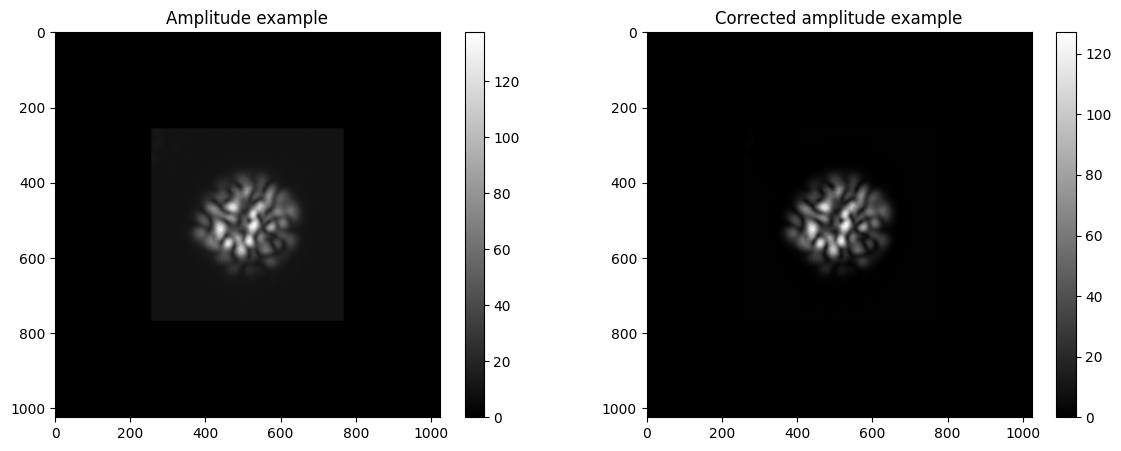

In [3]:
noise_corr = spr.utils.extract_noise_correction(CL, mask_trsh=0.02, plot_result=True)
print(noise_corr)

14.711394075896902


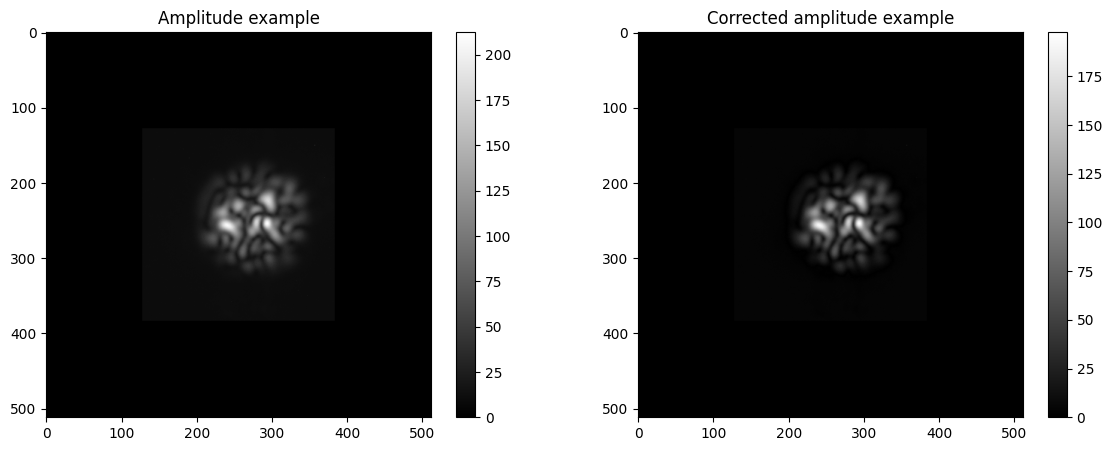

In [4]:
noise_corrCP = spr.utils.extract_noise_correction(CP, mask_trsh=0.02, plot_result=True)
print(noise_corrCP)

Let's detect the average centroids

In [7]:
centroids_CP = spr.utils.extract_average_centroid(CP)
centroids_CL = spr.utils.extract_average_centroid(CL)

print(f"Average centroid CP: {centroids_CP}")
print(f"Average centroid CL: {centroids_CL}")

Average centroid CP: (123.89196040180474, 139.87774360551484)
Average centroid CL: (253.0698997626044, 253.59593625159053)


### Data preparation

Select data for phase retrieval

In [8]:
idx = 7
random: bool = True
if random:
    idx = np.random.randint(0, len(CP[0]))

(314, 314) 42165287.643134035
(314, 314) 1448930.7518918912


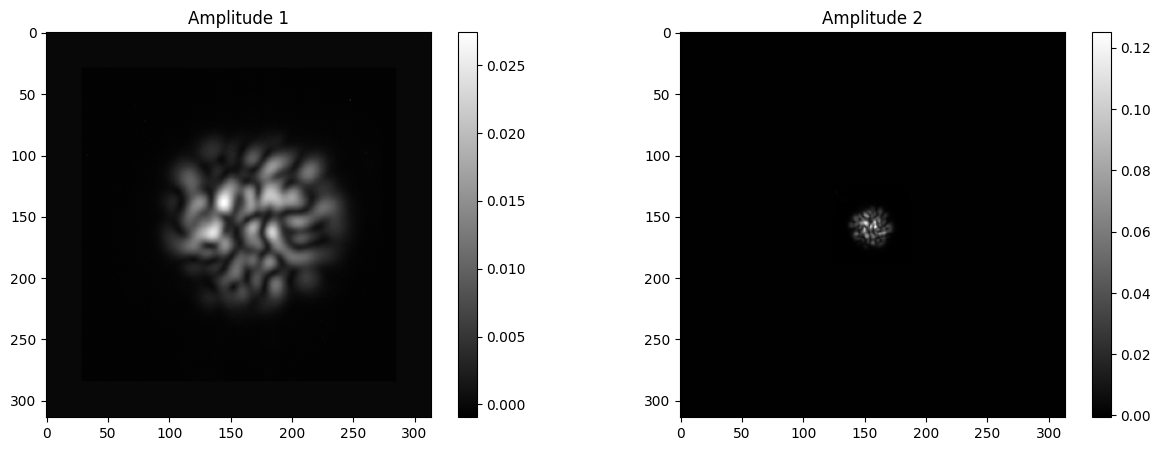

In [9]:
field = np.sqrt(CP[0][idx]) - noise_corrCP
start = 253
stop = start + 314

CP_shift = (np.array(centroids_CP) - np.array(field.shape) / 2).astype(int)
field = np.roll(field, shift=-CP_shift, axis=(0,1))
field = spr.transforms.pad_img(field, 0.23)
# field = field[156:-157, 156:-157]
# field = field[start:stop, start:stop]
# field = field[:-1, :-1]

field_energy = np.sum(np.square(np.abs(field)))
field = field / np.sqrt(field_energy)
print(field.shape, field_energy)


ft = np.sqrt(CL[0][idx]) - noise_corr
CL_shift = (np.array(centroids_CL) - np.array(ft.shape) / 2).astype(int) + np.array([-20, 10])
ft = np.roll(ft, shift=-CL_shift, axis=(0,1))
# ft = ft[:-1,:-1]
ft = spr.utils.bin_image(ft, factor=8)
# ft = spr.transforms.pad_img(ft, 3.92)
ft = spr.transforms.pad_img(ft, 3.92)

ft_energy = np.sum(np.square(np.abs(ft)))
ft = ft / np.sqrt(ft_energy)
print(ft.shape, ft_energy)

# _ = spr.plots.compare_arrays(field[1000:1500,1000:1500], ft[1000:1500,1000:1500], cmap='gray')
_ = spr.plots.compare_arrays(field, ft, cmap='gray')

Check that the Fourier transform of the field matches with the measured (perhaps resampled) one. Any shift will lead to a phase slope in the retrieved phase

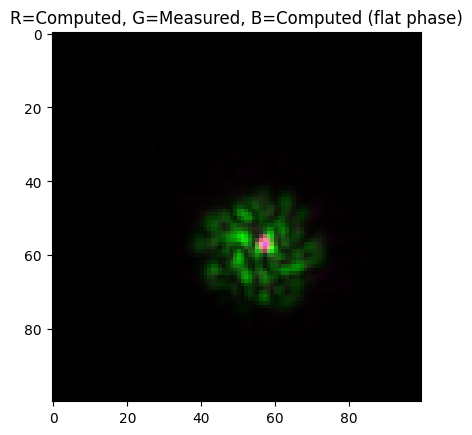

In [10]:
ft_field_flat = spr.transforms.fourier_transform(np.abs(field))
ft_field = spr.transforms.fourier_transform(field)

_ = spr.plots.rgb_imshow([np.abs(ft_field[100:200, 100:200])*0.5, np.abs(ft[100:200, 100:200])*0.5,  np.abs(ft_field_flat[100:200, 100:200])])
_ = plt.title("R=Computed, G=Measured, B=Computed (flat phase)")

Define the phase retrieval support

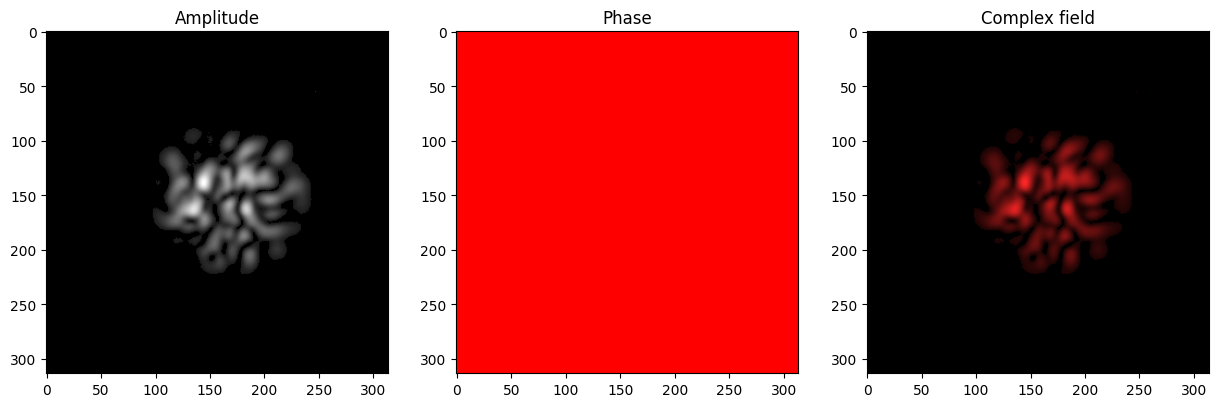

In [11]:
support = spr.supports.threshold_support(field, threshold=0.01)
supported_field = field.copy()
supported_field[np.logical_not(support)] = 0
_ = spr.plots.complex_imshow(supported_field)

### Phase retrieval

Run the phase retrieval. From now, a good setup includes:
- Flat phases initialization
- HIO iterations to refine the phase initialization
- ER iterations to converge to the solution

1 / 1
Pearson: 1.0


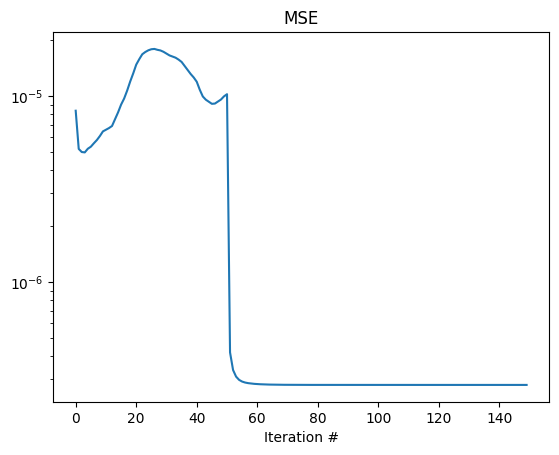

In [13]:
init = spr.initializers.flat_phases(np.abs(field))
y_hat, ft_hat, results = spr.retrieval.hio_er_fourier((np.abs(field), np.abs(ft)), support, pad=None, init=init, beta=0.99, max_iter=1, max_er_iter=100, max_hio_iter=50)
print(f"Pearson: {spr.metrics.pearson(y_hat[support], field[support])}")

plt.figure()
plt.plot(results['mse_plane2'], label='Fourier MSE')
plt.title('MSE')
plt.xlabel('Iteration #')
plt.yscale('log')

Check the results with the target, and display the phase difference with the target (it is likely to contain a phase slope due to Fourier magnitudes misalignments)

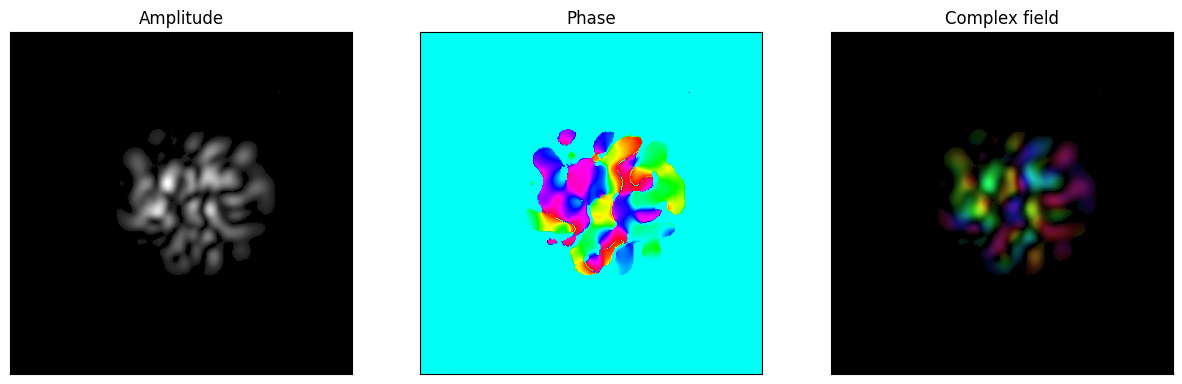

In [15]:
_ = spr.plots.complex_imshow(y_hat, remove_ticks=True,)
plt.show()

### Testing other phase retrieval algorithms !?!

There are plenty of them based on iterative projections/reflections. It seems that RAAR works well.

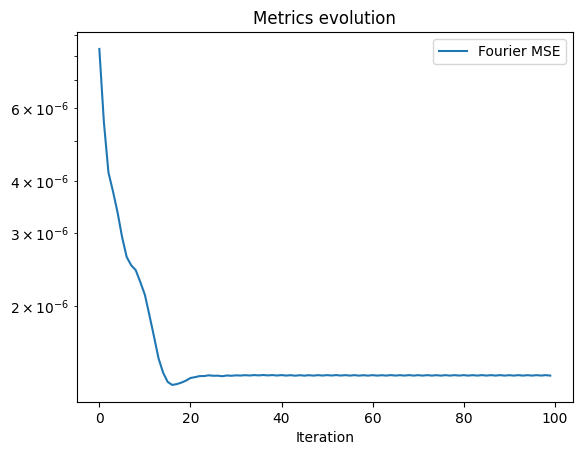

In [22]:
x, results = spr.retrievalmath.run(
        magnitudes=(np.abs(field), np.abs(ft)),
        support=support,
        init=spr.initializers.flat_phases(magnitude=np.abs(field)),
        algorithm=spr.retrievalmath.RAAR,
        algorithm_kwargs={'beta': 0.7},
        max_iter=100,
        rel_tol=1e-7,
        )
x_hat = np.abs(field) * np.exp(1j * np.angle(x))
x_hat[np.logical_not(support)] = 0

spr.retrievalmath.report_convergence_results(results)

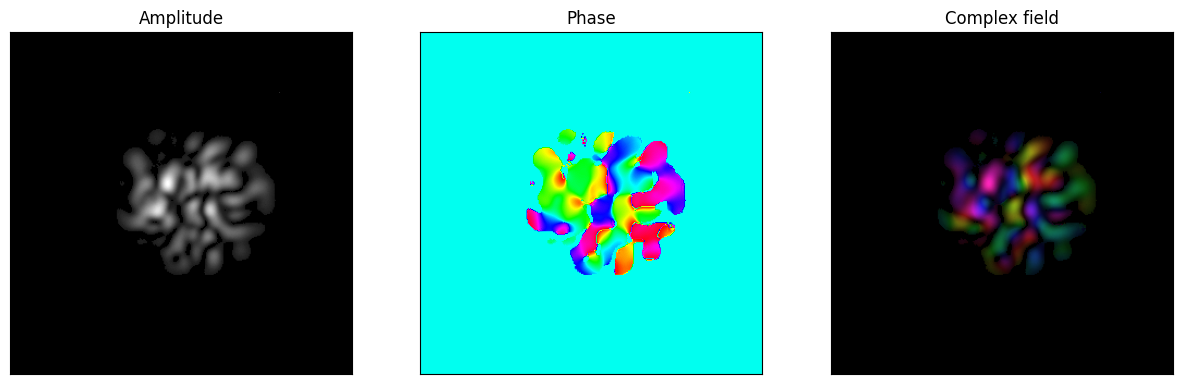

In [23]:
_ = spr.plots.complex_imshow(x_hat, remove_ticks=True,)
plt.show()

Attempt to remove the slope: might work if it is faint (not wrapped)

In [38]:
from scipy.optimize import curve_fit

def func_lin(x, a, b, c):
    return a * x[0] + b * x[1] + c

x_grid = np.arange(0, x_hat.shape[0])
y_grid = np.arange(0, x_hat.shape[1])
X, Y = np.meshgrid(x_grid, y_grid)
X_supp, Y_supp = X[support], Y[support]

x_hat[np.logical_not(support)] = np.nan
x_fit_data = np.vstack((X_supp.reshape((1, X_supp.size)), Y_supp.reshape((1, Y_supp.size))))
y_fit_data = np.angle(x_hat[~np.isnan(x_hat)])
print(x_fit_data.shape, y_fit_data.shape)

# Curve fit
popt, pcov = curve_fit(func_lin, x_fit_data, y_fit_data)
print("fitted: {}".format(popt))
z_fit = func_lin(x_fit_data, *popt)

(2, 12118) (12118,)
fitted: [ 1.70998479e-02  2.75279047e-03 -3.29238883e+00]


Std: 1.620842128090639 rad
Lambda / X rms: 3.9 rms


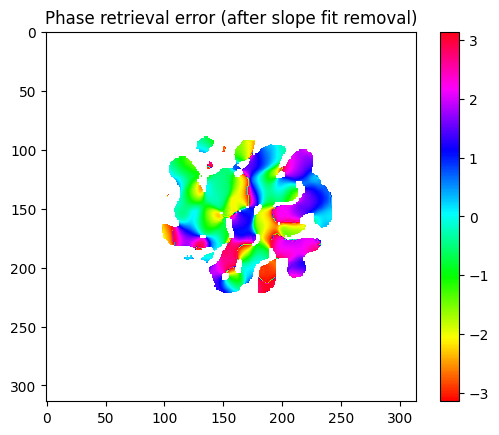

In [41]:
corr = np.zeros_like(np.abs(x_hat)) * np.nan
corr[support] = np.angle(np.exp(1j * (np.angle(x_hat[support]) - z_fit)))

print(f"Std: {np.nanstd(corr)} rad")
print(f"Lambda / X rms: {2 * np.pi / np.nanstd(corr):3.1f} rms")

plt.figure()
plt.imshow(corr, cmap='hsv')
plt.title("Phase retrieval error (after slope fit removal)")
plt.colorbar()